In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import json
import clustering
from clustering.what_if_model import WhatIfModel
from clustering.pqp_input_parser import PQPInputParser
from clustering.util import create_model
import autoreload
%load_ext autoreload
%autoreload 2

In [8]:
pqp_parser = PQPInputParser("tpch", f"~/Dokumente/repos/example_plugin/TPC-H__SF_1.000000__RUNS_10__TIME_5000__ENCODING_DictionaryFSBA")
m = create_model("lineitem", pqp_parser, 2)

unfair_training/models/


In [ ]:
m.suggest_clustering(30)
#m.estimate_total_runtime(['l_orderkey'], 'l_orderkey', [100])
#m.table_scans

In [4]:
def histogram(values, bins):
    def elements_between(low, high, upper_exclusive=True):
        if upper_exclusive:        
            filtered = filter(lambda x: low <= x and x < high, values)
        else:
            filtered = filter(lambda x: low <= x and x <= high, values)
            
        return len(list(filtered))
    
    return [elements_between(low, high ) for low, high in zip(bins, bins[1:])]

In [9]:
def eval_join_step(m, step, sided=True):
    side = None
    if step == "BUILD_SIDE_MATERIALIZING" or step == "BUILDING":
        side = "BUILD"
    elif step == "PROBE_SIDE_MATERIALIZING" or step == "PROBING":
        side = "PROBE"
    
    
    if step == "ALL":
        measured_column = "RUNTIME_NS"
        estimate_column = "RUNTIME_ESTIMATE"
    else:
        measured_column = step + "_NS"
        estimate_column = "ESTIMATE_" + step
    
    m.estimate_total_runtime([CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
    #m.estimate_total_runtime(["l_shipdate", "l_orderkey"], "l_orderkey", [20, 50])
    #m.estimate_total_runtime(["ss_sold_time_sk"], "ss_ticket_number", [100])
    
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_BUILD_SIDE_MATERIALIZING'] < 0]) == 0, "not all runtimes computed"
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_PROBE_SIDE_MATERIALIZING'] < 0]) == 0, "not all runtimes computed"
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_CLUSTERING'] < 0]) == 0, "not all runtimes computed"
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_BUILDING'] < 0]) == 0, "not all runtimes computed"
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_PROBING'] < 0]) == 0, "not all runtimes computed"
    #assert len(m.join_estimates[m.join_estimates['ESTIMATE_OUTPUT_WRITING'] < 0]) == 0, "not all runtimes computed"
    print(f"there are {len(m.join_estimates[m.join_estimates['RUNTIME_ESTIMATE'] < 0])} unestimated joins")
    print(m.join_estimates[m.join_estimates['RUNTIME_ESTIMATE'] < 0])
    assert len(m.join_estimates[m.join_estimates['RUNTIME_ESTIMATE'] == -1]) == 0, "not all runtimes computed"
    
    CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/TPC-H__SF_1.000000__RUNS_10__TIME_5000__ENCODING_DictionaryFSBA"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/{CLUSTERING_COLUMN}-100"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_shipdate-20_l_orderkey-50"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpcds/sf10-2d/04-ss_sold_time_sk-100_ss_ticket_number-1/"
    clustered_stats_parser = PQPInputParser("tpch", CLUSTERED_STATISTICS_PATH)
    clustered_stats_parser.load_statistics()
    clustered_joins = clustered_stats_parser.get_joins()
    #clustered_joins = load_join_statistics(path=CLUSTERED_STATISTICS_PATH)
    clustered_joins = clustered_joins.sort_values(['QUERY_HASH', 'DESCRIPTION'])
    
    print(f"there are {len(m.joins)} joins in the model")
    print(f"there are {len(clustered_joins)} clustered joins")
    
    frequencies = clustered_stats_parser.get_query_frequencies()
    current_sum = m.joins.apply(lambda x: x[measured_column] * frequencies[x['QUERY_HASH']], axis=1).sum()
    estimate_sum = int(m.join_estimates.apply(lambda x: x[estimate_column] * frequencies[x['QUERY_HASH']], axis=1).sum())
    new_sum = clustered_joins.apply(lambda x: x[measured_column] * frequencies[x['QUERY_HASH']], axis=1).sum()
    
    print(f"current : {current_sum}")
    print(f"estimate: {estimate_sum}")
    print(f"new     : {new_sum}")
    
    if side is not None and sided:
        clustered_joins = clustered_joins[clustered_joins[f"{side}_TABLE"] == table_name]
        print(f"{len(clustered_joins)} joins with {table_name} as the {side} side")
    
    m.join_estimates.sort_values(['QUERY_HASH', 'DESCRIPTION'], inplace=True)
    estimates = m.join_estimates.loc[clustered_joins.index]
    assert len(estimates) == len(clustered_joins), "lengths do not match"
    #assert len(estimates) == len(estimates[estimates[f"{side}_TABLE"] == table_name]), "did not get all rows"

    if side is not None and sided:
        current_sum = m.joins.loc[clustered_joins.index].apply(lambda x: x[measured_column] * frequencies[x['QUERY_HASH']], axis=1).sum()
        estimate_sum = int(estimates.apply(lambda x: x[estimate_column] * frequencies[x['QUERY_HASH']], axis=1).sum())
        new_sum = clustered_joins.apply(lambda x: x[measured_column] * frequencies[x['QUERY_HASH']], axis=1).sum()
        
        print(f"current : {current_sum}")
        print(f"estimate: {estimate_sum}")
        print(f"new     : {new_sum}")
          
    result = pd.DataFrame()
    if side is not None and sided:
        result['COLUMN_NAME'] = np.array(clustered_joins[f"{side}_COLUMN"])
    result['DESCRIPTION1'] = np.array(estimates['DESCRIPTION'])
    result['DESCRIPTION2'] = np.array(clustered_joins['DESCRIPTION'])
    result['QUERY_HASH1'] = np.array(estimates['QUERY_HASH'])
    result['QUERY_HASH2'] = np.array(clustered_joins['QUERY_HASH'])
    result['RUNTIME_BASE'] = np.array(estimates[measured_column])
    #result['RUNTIME_ESTIMATE'] = np.array(estimates[f"ESTIMATE_{step}"], dtype=np.int64)
    result['RUNTIME_ESTIMATE'] = np.array(estimates[estimate_column], dtype=np.int64)
    result['RUNTIME_CLUSTERED'] = np.array(clustered_joins[measured_column])
    
    
    # make sure we match all operators
    matches = result.apply(lambda row: row['DESCRIPTION1'] == row['DESCRIPTION2'] and row['QUERY_HASH1'] == row['QUERY_HASH2'], axis=1)
    assert matches.all(), "not all rows match"
    
    result['TOTAL_ERROR'] = result['RUNTIME_CLUSTERED'] - result['RUNTIME_ESTIMATE']
    result['RELATIVE_ERROR'] = result['RUNTIME_CLUSTERED'] / result['RUNTIME_ESTIMATE']
    if step == "CLUSTERING":
        result['RELATIVE_ERROR'].fillna(1, inplace=True)
    
    return result
    
CLUSTERING_COLUMN = "l_shipdate"
SIDED = False
results = eval_join_step(m, "ALL", SIDED)
#results = results[CLUSTERING_COLUMN == results['COLUMN_NAME']]
#results = results[results['COLUMN_NAME'] == 'l_orderkey']

print(results['RELATIVE_ERROR'].min())
print(results['RELATIVE_ERROR'].max())
#results = results[results['RUNTIME_BASE'] > 5e8]
#print(f"there are {len(results)} joins")
#results[results['QUERY_HASH1'] == "306bc6df7241ccf9"]
#[results['RUNTIME_BASE'] != results['RUNTIME_ESTIMATE']]
results[results['RELATIVE_ERROR'] < 0][['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
adding column UNSKIPPED_CHUNK_RATIO
## Estimating ColumnVsValue scans
adding column PREDICATE_GreaterThan
adding column PREDICATE_GreaterThanEquals
adding column PREDICATE_NotEquals
adding column UNSKIPPED_CHUNK_RATIO

## Estimating REFERENCE DATA joins
adding column BUILD_INPUT_COLUMN_SORTED_Ascending
adding column PROBE_INPUT_COLUMN_SORTED_No
## Estimating REFERENCE REFERENCE joins
adding column BUILD_INPUT_COLUMN_SORTED_Ascending

there are 0 unestimated joins
Empty DataFrame
Columns: [QUERY_HASH, DESCRIPTION, ESTIMATE_BUILD_SIDE_MATERIALIZING, ESTIMATE_PROBE_SIDE_MATERIALIZING, ESTIMATE_CLUSTERING, ESTIMATE_BUILDING, ESTIMATE_PROBING, ESTIMATE_OUTPUT_WRITING, BUILD_SIDE_MATERIALIZING_NS, PROBE_SIDE_MATERIALIZING_NS, CLUSTERING_NS, BUILDING_NS, PROBING_NS, OUTPUT_WRITING_NS, RUNTIME_NS, RUNTIME_ESTIMATE]
Index: []
there are 785 joins in the model
there are 785 clustered joins
current : 29611334381
estimate: 22947982523
new     : 29611334381
0.030579

,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR


[0, 0, 0, 1, 10, 8, 17, 4, 20, 53, 89, 85, 187, 156, 60, 78, 38, 1, 41, 10, 0, 0]
within 30%: 166/858 (19.34731934731935%)


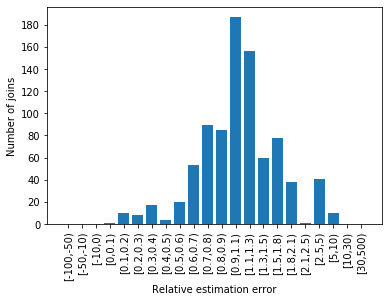

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

frequencies = pqp_parser.get_query_frequencies()

all_factors = []
for _, row in results.iterrows():
    frequency = frequencies[row['QUERY_HASH1']]
    for _ in range(frequency):
        all_factors.append(row['RELATIVE_ERROR'])
#factors = results['RELATIVE_ERROR']
#factors = list(map(lambda x: x if x >= 0 else -1/x, factors))

bins = [-100, -50, -10, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.8, 2.1, 2.5, 5, 10, 30, 500]



values = histogram(all_factors, bins)
print(values)
thirty_percent_range = values[7] + values[8] + values[9] + values[10]
print(f"within 30%: {thirty_percent_range}/{sum(values)} ({100*thirty_percent_range/sum(values)}%)")
x = np.arange(len(values))
labels = list([f"[{low},{high})" for low, high in zip(bins, bins[1:])])

fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Relative estimation error")
ax.set_ylabel("Number of joins")
ax.bar(x, values)
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
#plt.title("Histogram of relative estimation errors")


extension = '' if SIDED else '_all'

#plt.savefig(f'/home/aloeser/Downloads/MA-Figures/pngs/operatoreval/join_materialize_probe_shipdate{extension}.png', dpi=600, bbox_inches='tight')
plt.show()

In [29]:
results[results['RELATIVE_ERROR'] <= 0]

,DESCRIPTION1,DESCRIPTION2,QUERY_HASH1,QUERY_HASH2,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,JoinHash (Inner Join where ps_partkey = p_part...,JoinHash (Inner Join where ps_partkey = p_part...,10a29f9a2f853b35,10a29f9a2f853b35,338822,-52845,338822,391667,-6.411619
6,JoinHash (Semi Join where ps_suppkey = s_suppk...,JoinHash (Semi Join where ps_suppkey = s_suppk...,10a29f9a2f853b35,10a29f9a2f853b35,413418,-12530916,413418,12944334,-0.032992
7,JoinHash (Semi Join where ps_suppkey = s_suppk...,JoinHash (Semi Join where ps_suppkey = s_suppk...,10a29f9a2f853b35,10a29f9a2f853b35,332186,-12530916,332186,12863102,-0.026509
15,JoinHash (Semi Join where l_suppkey = ps_suppk...,JoinHash (Semi Join where l_suppkey = ps_suppk...,140261541ac6b6ba,140261541ac6b6ba,10107660,-129754,10107660,10237414,-77.898639
16,JoinHash (Semi Join where n_nationkey = s_nati...,JoinHash (Semi Join where n_nationkey = s_nati...,140261541ac6b6ba,140261541ac6b6ba,344060,-13513282,344060,13857342,-0.025461
17,JoinHash (Semi Join where ps_partkey = l_partk...,JoinHash (Semi Join where ps_partkey = l_partk...,140261541ac6b6ba,140261541ac6b6ba,5239062,-10506095,5239062,15745157,-0.498669
19,JoinHash (Semi Join where s_nationkey = n_nati...,JoinHash (Semi Join where s_nationkey = n_nati...,140261541ac6b6ba,140261541ac6b6ba,114198,-11958224,114198,12072422,-0.009550
24,JoinHash (Inner Join where ps_partkey = p_part...,JoinHash (Inner Join where ps_partkey = p_part...,1f28a146cc97b628,1f28a146cc97b628,332327,-52845,332327,385172,-6.288712
30,JoinHash (Semi Join where ps_suppkey = s_suppk...,JoinHash (Semi Join where ps_suppkey = s_suppk...,1f28a146cc97b628,1f28a146cc97b628,416420,-12530916,416420,12947336,-0.033231
31,JoinHash (Semi Join where ps_suppkey = s_suppk...,JoinHash (Semi Join where ps_suppkey = s_suppk...,1f28a146cc97b628,1f28a146cc97b628,349927,-12530916,349927,12880843,-0.027925


In [ ]:
percentile_bounds = [[1, 1.5], [1.5, 3], [3, 100]]
percentiles = []

for bound in percentile_bounds:
    mi = bound[0]
    ma = bound[1]
    high = results[results['RELATIVE_ERROR'] < ma]
    high = high[high['RELATIVE_ERROR'] >= mi]
    low = results[results['RELATIVE_ERROR'] <= 1/mi]
    low = low[low['RELATIVE_ERROR'] > 1/ma]    
    percentiles.append(len(low) + len(high))
    
np.array(percentiles) * 100 / len(results)
#33 44

In [11]:
import sklearn.metrics

ESTIMATE_COLUMN = "RUNTIME_ESTIMATE"
MEASURED_COLUMN = "RUNTIME_CLUSTERED"

frequencies = pqp_parser.get_query_frequencies()

estimates_ms = results.apply(lambda x: x[ESTIMATE_COLUMN] * frequencies[x['QUERY_HASH1']] / 1e6, axis=1)
measured_ms = results.apply(lambda x: x[MEASURED_COLUMN] * frequencies[x['QUERY_HASH1']] / 1e6, axis=1)


mse_nanoseconds = sklearn.metrics.mean_squared_error(measured_ms, estimates_ms)
#sum_relative_error = results[ESTIMATE_COLUMN].sum / results(MEASURED_COLUMN).sum()



def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

print(f"there are {len(results)} operators")
print(f"total estimate: {estimates_ms.sum()}")
print(f"total measured: {measured_ms.sum()}")
print(f"MSE: {mse_nanoseconds}")
print(f"SMAPE: {smape(measured_ms, estimates_ms)}")


there are 785 operators
total estimate: 22947.982523
total measured: 29611.334381
MSE: 733.8630969369968
SMAPE: 32.42455812919919


In [12]:
def eval_scans(m):
    m.estimate_total_runtime([CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
    #m.estimate_total_runtime(['l_shipdate', 'l_orderkey'], 'l_orderkey', [20, 50])
    assert len(m.scan_estimates[m.scan_estimates['RUNTIME_ESTIMATE'] < 0]) == 0, "not all runtimes computed"

    CLUSTERED_STATISTICS_PATH = "~/Dokumente/repos/example_plugin/TPC-H__SF_1.000000__RUNS_10__TIME_5000__ENCODING_DictionaryFSBA"
    #CLUSTERED_STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/{CLUSTERING_COLUMN}-100"
    #CLUSTERED_STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_shipdate-20_l_orderkey-50"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpcds/sf10-2d/04-ss_sold_time_sk-100_ss_ticket_number-1"
    
    path = f"{CLUSTERED_STATISTICS_PATH}/table_scans.csv"
    clustered_scans = pd.read_csv(path, sep='|')
    clustered_scans = clustered_scans[clustered_scans['TABLE_NAME'] == m.table_name]
    clustered_scans = clustered_scans.sort_values(['QUERY_HASH', 'DESCRIPTION'])
    
    print(f"there are {len(m.scan_estimates)} scan estimates")
    print(f"there are {len(clustered_scans)} clustered scans")
    
    m.scan_estimates.sort_values(['QUERY_HASH', 'DESCRIPTION'], inplace=True)
    result = pd.DataFrame()
    result['QUERY_HASH'] = np.array(clustered_scans['QUERY_HASH'])
    result['rti'] = np.array(m.scan_estimates['time_per_input_row'])
    result['COLUMN_NAME'] = np.array(clustered_scans['COLUMN_NAME'])
    result['DESCRIPTION1'] = np.array(m.scan_estimates['DESCRIPTION'])
    result['DESCRIPTION2'] = np.array(clustered_scans['DESCRIPTION'])
    result['QUERY_HASH1'] = np.array(m.scan_estimates['QUERY_HASH'])
    result['QUERY_HASH2'] = np.array(clustered_scans['QUERY_HASH'])
    result['RUNTIME_BASE'] = np.array(m.scan_estimates['RUNTIME_NS'])
    result['RUNTIME_ESTIMATE'] = np.array(m.scan_estimates.apply(lambda row: row['RUNTIME_ESTIMATE'] / m.query_frequency(row['QUERY_HASH']), axis=1), dtype=np.int64)
    result['RUNTIME_CLUSTERED'] = np.array(clustered_scans['RUNTIME_NS'])
    
    # make sure we match all operators
    matches = result.apply(lambda row: row['DESCRIPTION1'] == row['DESCRIPTION2'] and row['QUERY_HASH1'] == row['QUERY_HASH2'], axis=1)
    assert matches.all(), "not all rows match"
    
    result['TOTAL_ERROR'] = result['RUNTIME_CLUSTERED'] - result['RUNTIME_ESTIMATE']
    result['RELATIVE_ERROR'] = result['RUNTIME_CLUSTERED'] / result['RUNTIME_ESTIMATE']
    
    return result
    
CLUSTERING_COLUMN = "l_shipdate"
results = eval_scans(m)
print(f" there are {len(results)} scans")
#results = results[CLUSTERING_COLUMN == results['COLUMN_NAME']]
#results = results["l_quantity" == results['COLUMN_NAME']]
#results = results[results['COLUMN_NAME'] == 'l_receiptdate']
#results = results[results['RELATIVE_ERROR'] != 1.0]
results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'rti', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['RUNTIME_CLUSTERED'], ascending=False)
#results[['QUERY_HASH', 'RUNTIME_CLUSTERED']].sort_values(['RUNTIME_CLUSTERED'], ascending=False)
#results.to_csv('detailed_estimates_shipdate_orderkey.csv')

## Estimating ColumnBetween scans
adding column UNSKIPPED_CHUNK_RATIO
## Estimating ColumnVsValue scans
adding column PREDICATE_GreaterThan
adding column PREDICATE_GreaterThanEquals
adding column PREDICATE_NotEquals
adding column UNSKIPPED_CHUNK_RATIO

## Estimating REFERENCE DATA joins
adding column BUILD_INPUT_COLUMN_SORTED_Ascending
adding column PROBE_INPUT_COLUMN_SORTED_No
## Estimating REFERENCE REFERENCE joins
adding column BUILD_INPUT_COLUMN_SORTED_Ascending

there are 91 scan estimates
there are 91 clustered scans
 there are 91 scans


,QUERY_HASH,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,rti,TOTAL_ERROR,RELATIVE_ERROR
1,1a48bd3a39e20462,TableScan Impl: ColumnVsValue l_shipdate <= '1...,238263239,9540609,238263239,20.050195,228722630,24.973588
4,3898d8ff5bfa1046,TableScan Impl: ColumnVsValue l_shipdate <= '1...,13327902,18291405,13327902,1.113944,-4963503,0.728643
45,7a589f8ab18426d6,TableScan Impl: ColumnVsValue l_shipdate <= '1...,13076457,18016518,13076457,1.094298,-4940061,0.725804
39,6fb3f7e54d76ceed,TableScan Impl: ColumnVsValue l_shipdate <= '1...,13028962,18051849,13028962,1.089551,-5022887,0.721752
56,9a1adec8eeee6ec1,TableScan Impl: ColumnVsValue l_shipdate <= '1...,12924683,12725721,12924683,1.090926,198962,1.015635
28,5aa537e0d658225a,TableScan Impl: ColumnVsValue l_shipdate <= '1...,12796934,12668927,12796934,1.087956,128007,1.010104
16,4e4cb5b90ba5de03,TableScan Impl: ColumnVsValue l_shipdate <= '1...,12741757,12519447,12741757,1.084391,222310,1.017757
81,f16984c46aa94970,TableScan Impl: ColumnVsValue l_shipdate <= '1...,11298882,12193961,11298882,0.952915,-895079,0.926597
32,6081c4fbd55e16ea,TableScan Impl: ColumnVsValue l_shipdate <= '1...,11220235,11940246,11220235,0.945270,-720011,0.939699
69,d4f9e149097d68f9,TableScan Impl: ColumnVsValue l_shipdate <= '1...,11197186,12725721,11197186,0.950277,-1528535,0.879886


[0, 0, 0, 0, 0, 0, 1, 5, 3, 55, 9, 6, 1, 0, 0, 10, 0, 1, 0]
within 30%: 72/91 (79.12087912087912%)


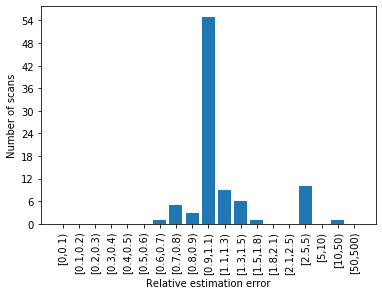

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

frequencies = pqp_parser.get_query_frequencies()

all_factors = []
for _, row in results.iterrows():
    frequency = frequencies[row['QUERY_HASH1']]
    for _ in range(frequency):
        all_factors.append(row['RELATIVE_ERROR'])
#factors = results['RELATIVE_ERROR']

#factors = list(map(lambda x: x if x >= 0 else -1/x, factors))

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.8, 2.1, 2.5, 5, 10, 50, 500]

values = histogram(all_factors, bins)
print(values)
thirty_percent_range = values[7] + values[8] + values[9] + values[10]
print(f"within 30%: {thirty_percent_range}/{sum(values)} ({100*thirty_percent_range/sum(values)}%)")

x = np.arange(len(values))
labels = list([f"[{low},{high})" for low, high in zip(bins, bins[1:])])

fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Relative estimation error")
ax.set_ylabel("Number of scans")
ax.bar(x, values)
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
#plt.title("Histogram of relative estimation errors")

#plt.savefig(f'/home/aloeser/Downloads/operatoreval/scan_partkey.pdf', bbox_inches='tight')
#plt.savefig(f'/home/aloeser/Downloads/MA-Figures/pngs/operatoreval/scan_shipdate.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
percentile_bounds = [[1, 1.5], [1.5, 3], [3, 100]]
percentiles = []

for bound in percentile_bounds:
    mi = bound[0]
    ma = bound[1]
    high = results[results['RELATIVE_ERROR'] < ma]
    high = high[high['RELATIVE_ERROR'] >= mi]
    low = results[results['RELATIVE_ERROR'] <= 1/mi]
    low = low[low['RELATIVE_ERROR'] > 1/ma]    
    percentiles.append(len(low) + len(high))
    
np.array(percentiles) * 100 / len(results)